In [1]:
# !pip install openeo
# !pip install matplotlib
# https://documentation.dataspace.copernicus.eu/APIs/openEO/openeo-community-examples/python/ForestFire/ForestFire.html

In [2]:
import scipy
import numpy as np

import openeo
from openeo.extra.spectral_indices import compute_indices

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import rasterio
from rasterio.plot import show

In [3]:
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()
extent = {"west": -2.6910, "south": 38.2239, "east": -2.5921, "north": 38.3002}

Authenticated using refresh token.


In [4]:
# define a function to identify cloud-free pixels in the available data-cube


def getBAP(scl, data, reducer="first"):
    mask = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10)

    # mask is a bit noisy, so we apply smoothening
    # 2D gaussian kernel
    g = scipy.signal.windows.gaussian(11, std=1.6)
    kernel = np.outer(g, g)
    kernel = kernel / kernel.sum()

    # Morphological dilation of mask: convolution + threshold
    mask = mask.apply_kernel(kernel)
    mask = mask > 0.1

    data_masked = data.mask(mask)

    # now select Best Available Pixel based on the mask
    return data_masked.reduce_dimension(reducer=reducer, dimension="t")

In [5]:
# load S2 pre-collection
s2pre = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-05-03", "2017-08-03"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2pre_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-05-03", "2017-08-03"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate ndvi
ndvi_pre = s2pre.ndvi()

In [6]:
# Create a Pre-event cloud free mosiac
ndvi_pre = getBAP(s2pre_scl, ndvi_pre, reducer="last")

In [7]:
ndvi_pre.download("NDVI.tiff")

In [8]:
# load S2 Near-real-time(NRT) collection
s2nrt = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-08-08"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2nrt_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-08-08"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

ndvi_nrt = s2nrt.ndvi()
ndvi_nrt = getBAP(s2nrt_scl, ndvi_nrt, reducer="first")

In [9]:
# download NDVI for NRT mode for comparison
ndvi_nrt.download("NRT_NDVI.tiff")

In [10]:
# download signal of fire in near real time
fire_nrt = ndvi_pre - ndvi_nrt
fire_nrt.download("NRT_Fire.tiff")

In [11]:
# load S2 post collection
s2post = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-11-03"],
    spatial_extent=extent,
    bands=["B04", "B08", "B12"],
    max_cloud_cover=90,
)

s2post_scl = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=["2017-08-03", "2017-11-03"],
    spatial_extent=extent,
    bands=["SCL"],
    max_cloud_cover=90,
)

# calculate post ndvi mosaic
ndvi_post = s2post.ndvi()
ndvi_post = getBAP(s2post_scl, ndvi_post, reducer="first")

In [12]:
# download NDVI for post-event mode for comparison
ndvi_post.download("Post_NDVI.tiff")

In [13]:
fire_mosiac = ndvi_pre - ndvi_post
fire_mosiac.download("Mosiac_Fire.tiff")

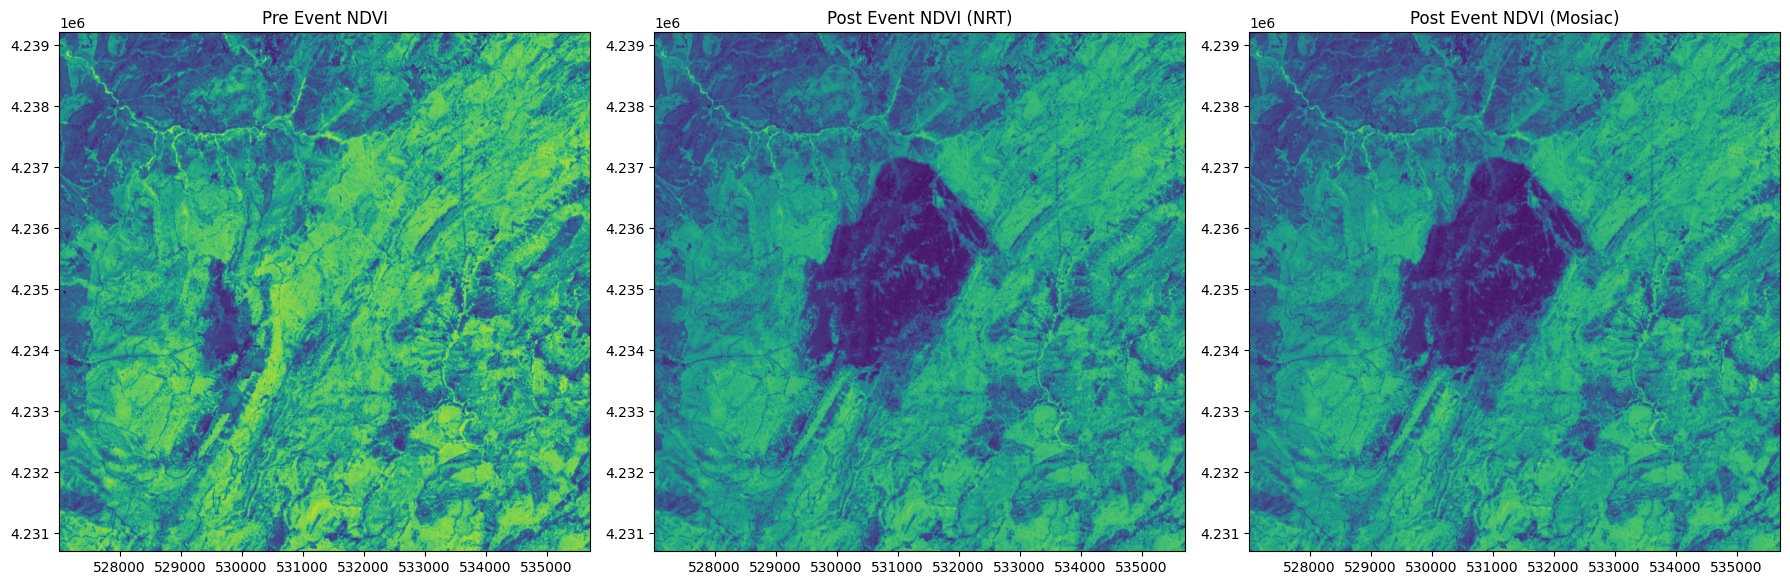

In [14]:
ndvi = rasterio.open("NDVI.tiff")
ndvi_nrt = rasterio.open("NRT_NDVI.tiff")
ndvi_mosiac = rasterio.open("Post_NDVI.tiff")

f, axarr = plt.subplots(1, 3, dpi=100, figsize=(18, 6))
im = show(ndvi.read(1), vmin=0, vmax=1, transform=ndvi.transform, ax=axarr[0])
axarr[0].set_title("Pre Event NDVI")

im = show(ndvi_nrt.read(1), vmin=0, vmax=1, transform=ndvi_nrt.transform, ax=axarr[1])
axarr[1].set_title("Post Event NDVI (NRT)")

im = show(
    ndvi_mosiac.read(1), vmin=0, vmax=1, transform=ndvi_mosiac.transform, ax=axarr[2]
)
axarr[2].set_title("Post Event NDVI (Mosiac)")
plt.tight_layout()